In [ ]:
"""
下载 PASCAL VOC 2007 数据集并转换为 YOLO 格式,生成 voc.yaml 文件
PASCAL VOC 2007 数据集是计算机视觉领域中一个著名的标准数据集，主要用于目标检测、图像分类和语义分割等任务。
该数据集包含 9963 张图片，分为训练集（5011 张）和测试集（4952 张），
涵盖 20 个类别，如飞机、自行车、鸟、船、瓶子、公共汽车、汽车、猫、椅子、牛、餐桌、狗、马、摩托车、人、盆栽、羊、沙发、火车和电视显示器。
其标注信息以 XML 格式存储，包含目标的边界框、类别标签等。该数据集是许多经典计算机视觉模型的训练和评估基准。
"""
import os
import requests
import tarfile
from lxml import etree
import shutil

# ----------------------
# 配置参数
# ----------------------
VOC_URL = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
VOC_TEST_URL = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar"
DATA_DIR = "./dataset/"

# ----------------------
# 下载并解压数据集
# ----------------------
def download_and_extract(url, dest_dir):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
    
    filename = os.path.join(dest_dir, url.split("/")[-1])
    
    # 下载文件
    if not os.path.exists(filename):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
    
    # 解压文件
    print(f"Extracting {filename}...")
    with tarfile.open(filename) as tar:
        tar.extractall(path=dest_dir)



# 转换VOC格式到YOLO格式
# ----------------------
def convert_voc_to_yolo(voc_dir, output_dir):
    print(f"转换VOC格式到YOLO格式: {output_dir}")

    classes = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

    # 创建训练和测试子目录
    for split in ["train", "test"]:
        os.makedirs(os.path.join(output_dir, f"images/{split}"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, f"labels/{split}"), exist_ok=True)

    # 对 trainval 和 test 分别处理
    for split in ["trainval", "test"]:
        split_type = "train" if split == "trainval" else "test"
        list_path = os.path.join(voc_dir, f"VOCdevkit/VOC2007/ImageSets/Main/{split}.txt")
        if not os.path.exists(list_path):
            print(f"划分文件不存在: {list_path}")
            continue

        with open(list_path) as f:
            ids = [line.strip() for line in f.readlines()]
        print(f"开始处理 {split_type} 集，共 {len(ids)} 张图片")

        for img_id in ids:
            ann_path = os.path.join(voc_dir, f"VOCdevkit/VOC2007/Annotations/{img_id}.xml")
            if not os.path.exists(ann_path):
                print(f"标注文件不存在: {ann_path}")
                continue

            tree = etree.parse(ann_path)
            root = tree.getroot()

            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            yolo_ann = []
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in classes:
                    continue
                cls_id = classes.index(cls)

                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)

                x_center = (xmin + xmax) / 2 / width
                y_center = (ymin + ymax) / 2 / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                yolo_ann.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

            # 保存 YOLO 标签
            label_out_path = os.path.join(output_dir, f"labels/{split_type}/{img_id}.txt")
            with open(label_out_path, "w") as f:
                f.write("\n".join(yolo_ann))

            # 拷贝图像
            src = os.path.join(voc_dir, f"VOCdevkit/VOC2007/JPEGImages/{img_id}.jpg")
            dst = os.path.join(output_dir, f"images/{split_type}/{img_id}.jpg")
            if not os.path.exists(dst):
                try:
                    shutil.copy2(src, dst)
                    # os.symlink(src, dst)  # 尝试创建符号链接                    
                except:
                    print(f"复制图像失败: {src}")

    # 创建 voc.yaml 文件
    with open("voc.yaml", "w") as f:
        names_str = '\n'.join([f"  {i}: {name}" for i, name in enumerate(classes)])
        f.write(
f"""path: {os.path.abspath(output_dir)}
train: images/train
val: images/train
test: images/test
names:
{names_str}
"""
        )
    print("✅ VOC 转 YOLO 完成，生成 voc.yaml")


# # 下载并解压训练集和测试集
download_and_extract(VOC_URL, DATA_DIR)
download_and_extract(VOC_TEST_URL, DATA_DIR)
# # 执行格式转换 voc->yolo
convert_voc_to_yolo(DATA_DIR, DATA_DIR+"/output")

Extracting ./dataset/VOCtrainval_06-Nov-2007.tar...
Extracting ./dataset/VOCtest_06-Nov-2007.tar...
转换VOC格式到YOLO格式:./dataset//output
转换完成！输出voc.yaml


In [ ]:
"""
基于YOLO V8的PASCAL VOC 2007的目标检测任务
"""
# !pip install ultralytics
# 使用预训练模型
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
device = 'cuda'  # 使用GPU训练,可选cuda或cpu
epochs=15  # 训练轮数
batch_size=64  # 批处理大小
imgsize=640  # 输入图像大小
lr=0.001    # 学习率,可选0.001、0.01、0.1等
augmentation=True  # 是否使用数据增强,可选True或False,对数据集进行旋转、缩放、翻转等操作,防止过拟合
optimizer='AdamW'  # 优化器,可选SGD、Adam、AdamW等,区别:SGD是随机梯度下降,Adam是自适应学习率优化器,AdamW是Adam的改进版,具有更好的收敛性和泛化能力

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# 加载数据集

train_path = 'voc.yaml'  # 训练集路径
test_path = ''  # 测试集路径


In [ ]:
!nvidia-smi
# 加载预训练模型
model = YOLO("baseModel/yolov8n.pt")  # 使用预训练模型
print("模型加载完成") if model else print("模型加载失败")

Mon Apr 14 12:22:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

100%|██████████| 6.25M/6.25M [00:00<00:00, 127MB/s]


模型加载完成


In [ ]:
# 训练模型
# 训练参数配置
model.train(
    data=train_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=imgsize,
    device=0 if device == "cuda" else "cpu",
    optimizer=optimizer,
    lr0=lr,
    augment=augmentation,
    save=True, # 是否保存模型,可选True或False
    exist_ok=True # 是否覆盖已有模型,可选True或False

)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=baseModel/yolov8n.pt, data=voc.yaml, epochs=15, time=None, patience=100, batch=15, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 123MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/output/labels... 9963 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9963/9963 [00:04<00:00, 2404.59it/s]


train: New cache created: /content/dataset/output/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/output/labels.cache... 9963 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9963/9963 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.32G      1.258      2.299      1.405         15        640: 100%|██████████| 665/665 [03:07<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:19<00:00,  4.18it/s]


                   all       9963      30638       0.39      0.308      0.265      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.96G      1.318      1.977      1.464         11        640: 100%|██████████| 665/665 [03:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:22<00:00,  4.03it/s]


                   all       9963      30638      0.456      0.392      0.369      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.99G      1.323      1.944      1.484          9        640: 100%|██████████| 665/665 [03:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:17<00:00,  4.28it/s]


                   all       9963      30638      0.568      0.454      0.491      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.99G      1.301      1.845      1.462          8        640: 100%|██████████| 665/665 [02:57<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:16<00:00,  4.33it/s]


                   all       9963      30638       0.58      0.458      0.494      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.99G      1.262      1.746      1.436         16        640: 100%|██████████| 665/665 [02:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:16<00:00,  4.37it/s]


                   all       9963      30638      0.665      0.545      0.601       0.38
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.99G      1.276      1.615      1.466         11        640: 100%|██████████| 665/665 [02:52<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:15<00:00,  4.41it/s]


                   all       9963      30638      0.657      0.545      0.605      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.99G      1.236      1.506      1.435         10        640: 100%|██████████| 665/665 [02:49<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:19<00:00,  4.21it/s]


                   all       9963      30638      0.671       0.58      0.643      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.99G      1.204      1.423      1.409          8        640: 100%|██████████| 665/665 [02:50<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:15<00:00,  4.40it/s]


                   all       9963      30638      0.702      0.597       0.67      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.99G      1.171       1.35      1.381          9        640: 100%|██████████| 665/665 [02:49<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:15<00:00,  4.43it/s]


                   all       9963      30638      0.749      0.628      0.715      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.99G      1.143      1.281      1.357         11        640: 100%|██████████| 665/665 [02:49<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:15<00:00,  4.39it/s]


                   all       9963      30638      0.762      0.649      0.739      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.99G      1.109      1.219      1.333         11        640: 100%|██████████| 665/665 [02:49<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:14<00:00,  4.45it/s]


                   all       9963      30638      0.781      0.669      0.764      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.99G       1.08      1.152      1.308          8        640: 100%|██████████| 665/665 [02:48<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:14<00:00,  4.48it/s]


                   all       9963      30638       0.79        0.7      0.786      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.99G      1.053      1.082      1.283         12        640: 100%|██████████| 665/665 [02:47<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:14<00:00,  4.46it/s]


                   all       9963      30638      0.802      0.708      0.798      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.99G      1.023      1.031      1.262          4        640: 100%|██████████| 665/665 [02:49<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:14<00:00,  4.48it/s]


                   all       9963      30638      0.824      0.736      0.825      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.99G          1     0.9865      1.242         11        640: 100%|██████████| 665/665 [02:50<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:20<00:00,  4.15it/s]


                   all       9963      30638      0.842      0.742      0.836      0.619

15 epochs completed in 1.052 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 333/333 [01:42<00:00,  3.24it/s]


                   all       9963      30638      0.821      0.737      0.826      0.622
             aeroplane        445        642      0.841      0.847      0.912      0.706
               bicycle        505        807       0.84      0.781      0.856      0.656
                  bird        622       1175      0.818      0.735      0.817      0.573
                  boat        364        791      0.771      0.626      0.733      0.485
                bottle        502       1291       0.79      0.584      0.704      0.471
                   bus        380        526      0.832        0.8      0.867      0.735
                   car       1536       3185      0.857      0.785      0.879      0.677
                   cat        676        759      0.861       0.83        0.9      0.757
                 chair       1117       2806      0.748      0.582      0.684      0.473
                   cow        273        685      0.789      0.788       0.85      0.621
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ab4f1343b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043


image 1/1 c:\Users\Spark\Desktop\vision\Demo4\VOC-VOLO-V8\dataset\output\images\test\000136.jpg: 480x640 1 cat, 19.1ms
Speed: 3.0ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


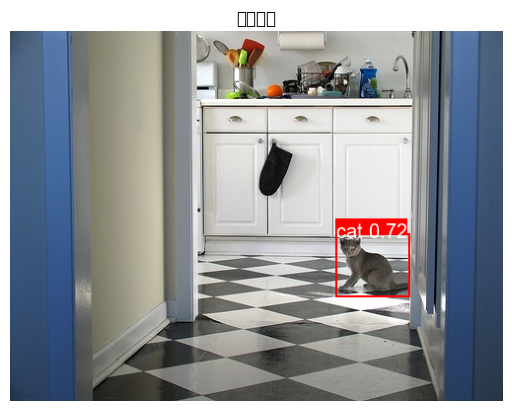

✅ 已保存图片: predict/000136.jpg


In [8]:
# 预测输出
import os
import cv2
import torch
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ------------ 全局配置 ------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "runs/detect/train/weights/best.pt"
model = YOLO(MODEL_PATH)
INPUT_PATH = "dataset/output/images/test/000136.jpg"  # 输入路径,可以为图片,视频,文件夹,摄像头编号
SAVE = True  # 是否保存预测结果
OUTPUT_PATH = "predict/"  # 预测结果保存路径

# ------------ 工具函数 ------------
def draw_boxes_pil(image, results):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cls_id = int(box.cls)
        conf = float(box.conf)
        label = f"{model.names[cls_id]} {conf:.2f}"

        text_bbox = font.getbbox(label)
        text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.rectangle([x1, y1 - text_h, x1 + text_w, y1], fill="red")
        draw.text((x1, y1 - text_h), label, fill="white", font=font)

    return image

def save_image(image, save_path, origin_path=None):
    if os.path.isdir(save_path):
        filename = os.path.basename(origin_path)
        save_path = os.path.join(save_path, filename)
    else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
    image.save(save_path)
    print(f"✅ 已保存图片: {save_path}")

# ------------ 单图预测 ------------
def predict_image(image_path, save=False, save_path=None):
    image = Image.open(image_path).convert("RGB")
    results = model.predict(image_path, imgsz=640, device=DEVICE)
    image = draw_boxes_pil(image, results)

    plt.imshow(image)
    plt.axis("off")
    plt.title("预测结果")
    plt.show()

    if save and save_path:
        save_image(image, save_path, origin_path=image_path)

# ------------ 视频预测 ------------
def predict_video(video_path, save=False, save_path=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ 视频文件无法打开")
        return

    if save:
        if os.path.isdir(save_path):
            filename = os.path.basename(video_path)
            save_path = os.path.join(save_path, f"{os.path.splitext(filename)[0]}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps, w, h = cap.get(5), int(cap.get(3)), int(cap.get(4))
        out = cv2.VideoWriter(save_path, fourcc, fps, (w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, imgsz=640, device=DEVICE)
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls)
            conf = float(box.conf)
            label = f"{model.names[cls_id]} {conf:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow("预测中 - 按 Q 退出", frame)
        if save:
            out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    if save:
        out.release()
        print(f"✅ 已保存视频: {save_path}")
    cv2.destroyAllWindows()

# ------------ 文件夹批量图片 ------------
def predict_folder(folder_path, save=False, output_dir=None):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                img_path = os.path.join(root, file)
                image = Image.open(img_path).convert("RGB")
                results = model.predict(img_path, imgsz=640, device=DEVICE)
                image = draw_boxes_pil(image, results)

                if save and output_dir:
                    rel_path = os.path.relpath(img_path, folder_path)
                    save_path = os.path.join(output_dir, rel_path)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    image.save(save_path)

    if save:
        print(f"✅ 文件夹预测完成，结果已保存至: {output_dir}")

# ------------ 摄像头实时预测 ------------
def predict_camera(index=0):
    cap = cv2.VideoCapture(index)
    if not cap.isOpened():
        print(f"❌ 无法打开摄像头 {index}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, imgsz=640, device=DEVICE)
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls)
            conf = float(box.conf)
            label = f"{model.names[cls_id]} {conf:.2f}"
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow("摄像头预测 - 按 Q 退出", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

# ------------ 总入口函数 ------------
def run_predict(path, save=False, save_path=None):
    if isinstance(path, int):
        predict_camera(index=path)
    elif os.path.isfile(path):
        ext = os.path.splitext(path)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]:
            predict_image(path, save, save_path)
        elif ext in [".mp4", ".avi", ".mov", ".mkv"]:
            predict_video(path, save, save_path)
    elif os.path.isdir(path):
        predict_folder(path, save, save_path)
    else:
        print("❌ 无效路径，请确认输入正确的图片/视频/文件夹/摄像头编号")

# ------------ 示例调用 ------------
run_predict(INPUT_PATH, SAVE, OUTPUT_PATH)      # 预测输出
